### 1 Configuración

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [0]:
CATALOG = "retail_catalog"
SCHEMA  = "retail_gold"
TABLE   = f"{CATALOG}.{SCHEMA}.retail_unified_allcols"
print("Tabla objetivo:", TABLE)

Tabla objetivo: retail_catalog.retail_gold.retail_unified_allcols


In [0]:
# df = pd.DataFrame()
df = spark.table(TABLE)

In [0]:
print("Filas:", df.count())
print("Columnas:", len(df.columns))

Filas: 3333
Columnas: 57


In [0]:
# t_totalPrice 
#t_quantity
# t_unitPrice
# t_product
# t_paymentMethod

kpis = (df
        .agg(
            F.sum("t_totalPrice").alias("total_sales"),
            F.sum("t_quantity").alias("units_sold"),
            F.countDistinct("customerID").alias("unique_customers"),
            F.countDistinct("franchiseID").alias("active_franchises")
        )
       ).collect()[0]
print("Ventas totales:", kpis["total_sales"])
print("Unidades vendidas:", kpis["units_sold"])
print("Clientes únicos:", kpis["unique_customers"])
print("Franquicias activas:", kpis["active_franchises"])

Ventas totales: 66471
Unidades vendidas: 22157
Clientes únicos: 300
Franquicias activas: 48


In [0]:
# Periodo de datos
periodo = df.select(F.min(F.col("t_year")).alias("min_year"),
                    F.max(F.col("t_year")).alias("max_year"),
                    F.min(F.col("t_month")).alias("min_month"),
                    F.max(F.col("t_month")).alias("max_month")).collect()[0]

print("Periodo (año):", periodo["min_year"], "→", periodo["max_year"])
print("Mes mínimo/máximo:", periodo["min_month"], "→", periodo["max_month"])

Periodo (año): 2024 → 2024
Mes mínimo/máximo: 5 → 5


### Lineas de tiempo 

t_year,t_month,total_sales
2024,5,66471


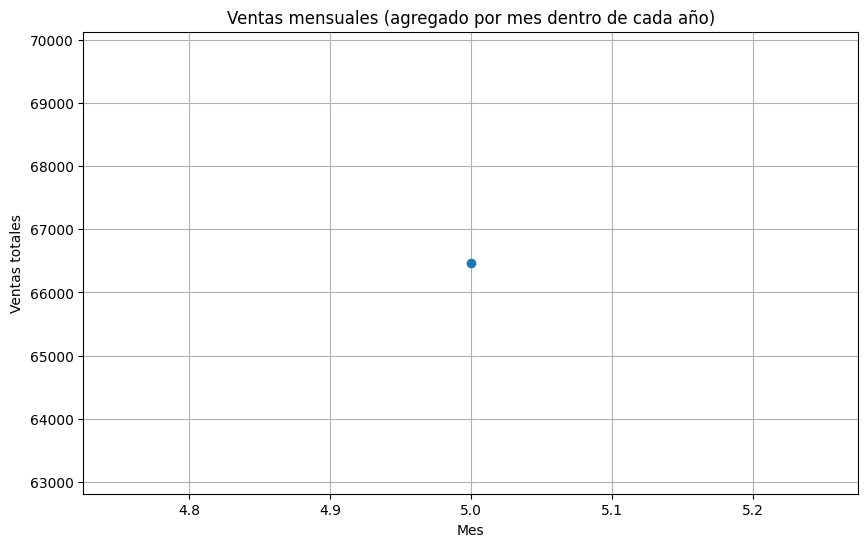

In [0]:
df_monthly = (df
              .groupBy("t_year","t_month")
              .agg(F.sum("t_totalPrice").alias("total_sales"))
              .orderBy("t_year","t_month"))

display(df_monthly)

# Gráfico (matplotlib): ventas mensuales (una sola figura)
pdf_monthly = df_monthly.toPandas()

plt.figure(figsize=(10,6))
plt.plot(pdf_monthly["t_month"], pdf_monthly["total_sales"], marker="o")
plt.title("Ventas mensuales (agregado por mes dentro de cada año)")
plt.xlabel("Mes")
plt.ylabel("Ventas totales")
plt.grid(True)
plt.show()

t_product,sales
Golden Gate Ginger,11595
Outback Oatmeal,11199
Austin Almond Biscotti,11148
Tokyo Tidbits,10986
Pearly Pies,10785
Orchard Oasis,10758


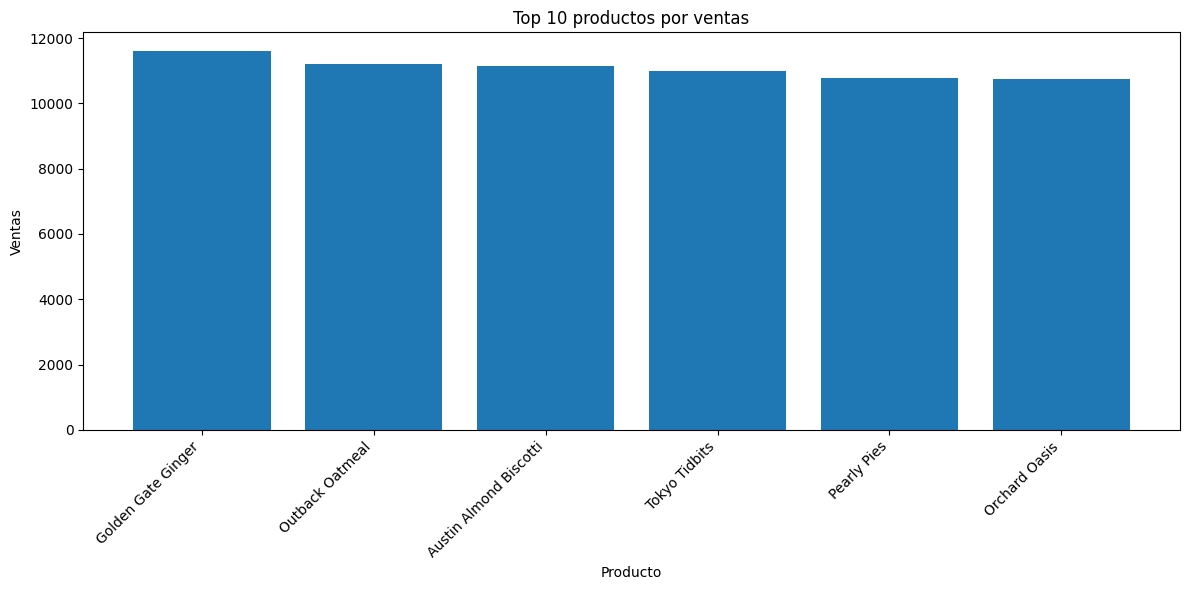

In [0]:
df_top_products = (df
                   .groupBy("t_product")
                   .agg(F.sum("t_totalPrice").alias("sales"))
                   .orderBy(F.desc("sales"))
                   .limit(10))

display(df_top_products)

pdf_top = df_top_products.toPandas()

plt.figure(figsize=(12,6))
plt.bar(pdf_top["t_product"], pdf_top["sales"])
plt.title("Top 10 productos por ventas")
plt.xlabel("Producto")
plt.ylabel("Ventas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

country,total_sales
Japan,21591
US,20736
Australia,8211
Italy,6642
Sweden,4512
France,1350
Netherlands,1239
Germany,1239
Canada,951


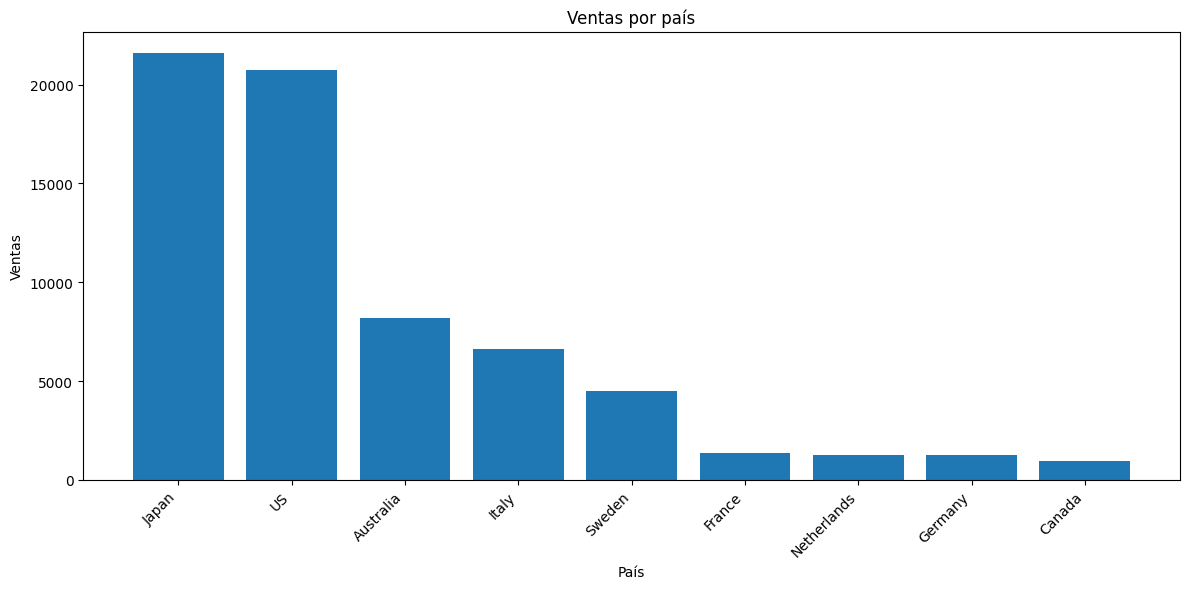

In [0]:
df_country = (df
              .withColumn("country",
                          F.coalesce(F.col("c_country"), F.col("f_country")))
              .groupBy("country")
              .agg(F.sum("t_totalPrice").alias("total_sales"))
              .orderBy(F.desc("total_sales")))

display(df_country)

pdf_country = df_country.toPandas()

plt.figure(figsize=(12,6))
plt.bar(pdf_country["country"], pdf_country["total_sales"])
plt.title("Ventas por país")
plt.xlabel("País")
plt.ylabel("Ventas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Contruccion de ETL

In [0]:
df_media_gold_reviews_chunked = spark.read.table('samples.bakehouse.media_gold_reviews_chunked')
df_sales_customers = spark.read.table('samples.bakehouse.sales_customers')
df_sales_franchises = spark.read.table('samples.bakehouse.sales_franchises')
df_sales_suppliers = spark.read.table('samples.bakehouse.sales_suppliers')
df_sales_transactions = spark.read.table('samples.bakehouse.sales_transactions')

In [0]:
from pyspark.sql import functions as F, Window
from pyspark.sql.types import TimestampType
from datetime import datetime

# ========= 1) Utilidades =========
audit_dt = datetime.now()

def enrich_with_time(df, datetime_col):
    return (df
            .withColumn("year", F.year(F.col(datetime_col)))
            .withColumn("month", F.month(F.col(datetime_col)))
            .withColumn("day", F.dayofmonth(F.col(datetime_col)))
            .withColumn("hour", F.hour(F.col(datetime_col)))
            .withColumn("audit_ingestion_date", F.lit(audit_dt).cast(TimestampType()))
            .withColumn("ingestion_year", F.year(F.lit(audit_dt)))
            .withColumn("ingestion_month", F.month(F.lit(audit_dt)))
            .withColumn("ingestion_day", F.dayofmonth(F.lit(audit_dt)))
           )

def prefixed_cols(df, alias_prefix, exclude=set()):
    """
    Devuelve una lista de columnas con alias/prefijo 'alias_prefix_' para evitar colisiones.
    Excluye columnas en 'exclude' (normalmente claves de join).
    """
    cols = []
    for c in df.columns:
        if c in exclude:
            continue
        cols.append(F.col(c).alias(f"{alias_prefix}_{c}"))
    return cols

In [0]:
df_t = enrich_with_time(df_sales_transactions, "dateTime")
df_c = df_sales_customers
df_f = df_sales_franchises
df_s = df_sales_suppliers
df_r = df_media_gold_reviews_chunked

### limpieza de duplicados

In [0]:
df_s = df_s.dropDuplicates(["supplierID"])
df_c = df_c.dropDuplicates(["customerID"])
df_f = df_f.dropDuplicates(["franchiseID"])

In [0]:
w = Window.partitionBy("franchiseID").orderBy(F.col("review_date").desc_nulls_last())
df_r_latest = (
    df_r
    .withColumn("_rn", F.row_number().over(w))
    .filter(F.col("_rn") == 1)
    .drop("_rn")
)

In [0]:
# Claves que dejamos sin prefijo:
join_keys = {"transactionID", "customerID", "franchiseID", "supplierID"}

t_cols = [F.col("transactionID"),
          F.col("customerID"),
          F.col("franchiseID")] + \
         prefixed_cols(df_t, "t", exclude=join_keys)

c_cols = [F.col("c.customerID").alias("customerID_ref")] + \
         [F.col(f"c.{c}").alias(f"c_{c}") for c in df_c.columns if c not in {"customerID"}]

f_cols = [F.col("f.franchiseID").alias("franchiseID_ref"),
          F.col("f.supplierID").alias("supplierID")] + \
         [F.col(f"f.{c}").alias(f"f_{c}") for c in df_f.columns if c not in {"franchiseID","supplierID"}]

s_cols = [F.col("s.supplierID").alias("supplierID_ref")] + \
         [F.col(f"s.{c}").alias(f"s_{c}") for c in df_s.columns if c not in {"supplierID"}]

r_cols = [F.col("r.franchiseID").alias("franchiseID_reviews_ref")] + \
         [F.col(f"r.{c}").alias(f"r_{c}") for c in df_r_latest.columns if c not in {"franchiseID"}]

# ========= 5) Joins y selección final =========
df_unified_all = (
    df_t.alias("t")
      .join(df_c.alias("c"),  on="customerID", how="left")
      .join(df_f.alias("f"),  on="franchiseID", how="left")
      .join(df_s.alias("s"),  on=F.col("f.supplierID") == F.col("s.supplierID"), how="left")
      .join(df_r_latest.alias("r"), on="franchiseID", how="left")
      .select(
          *t_cols,
          *c_cols,
          *f_cols,
          *s_cols,
          *r_cols
      )
      # Métricas adicionales (puedes añadir más)
      .withColumn("t_transaction_volume", F.col("t_quantity") * F.col("t_unitPrice"))
      .withColumn("data_source", F.lit("unified_retail_all_columns"))
)

# (Opcional) enmascarar datos sensibles si existen en algún DF (p.ej., t_cardNumber)
if "t_cardNumber" in df_unified_all.columns:
    df_unified_all = (df_unified_all
                      .withColumn("t_cardNumber_last4", F.col("t_cardNumber") % 10000)
                      .drop("t_cardNumber"))

# ========= 6) Persistencia en Delta/Unity Catalog (partición por ingestión) =========
spark.sql("CREATE CATALOG IF NOT EXISTS retail_catalog")
spark.sql("CREATE SCHEMA IF NOT EXISTS retail_catalog.retail_gold")

(df_unified_all
 .write
 .mode("overwrite")
 .format("delta")
 .partitionBy("t_ingestion_year", "t_ingestion_month")
 .saveAsTable("retail_catalog.retail_gold.retail_unified_allcols_dos"))

print("✅ Tabla final con todas las columnas: retail_catalog.retail_gold.retail_unified_allcols")
print("Columnas totales:", len(df_unified_all.columns))

✅ Tabla final con todas las columnas: retail_catalog.retail_gold.retail_unified_allcols
Columnas totales: 57
